In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import math
from random import choices
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from jsonlines import jsonlines
from typing import Dict, List, Any
from matplotlib import pyplot as plt

from src.settings import PREPROCESSED_DIR, MODELS_DIR, LOGS_DIR

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # return torch.device('cpu')

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, vocab_size):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x): # batched tokens ids
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out

  
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x
    
class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

class FrameLandmarksEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_frames, d_model, n_landmarks=99):
        super().__init__()
        self.max_sequence_length = max_frames
        self.linear = nn.Linear(n_landmarks, d_model)
        self.position_encoder = PositionalEncoding(d_model, self.max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):  # seq of frames (landmarks), batched
        # in: (batch_size, n_frames, 99)
        # x = x[:, :self.max_sequence_length, :]
        # x = F.pad(x, (0, 0, 0, self.max_sequence_length - x.size(1)), value=-1)
        x = self.linear(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        # out: (batch_size, max_sequence_length, d_model)
        return x

class Encoder(nn.Module):
    def __init__(self, 
                 d_model, 
                 ffn_hidden, 
                 num_heads, 
                 drop_prob, 
                 num_layers,
                 max_sequence_length
                ):
        super().__init__()
        # self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.frames_seq_embedding = FrameLandmarksEmbedding(max_sequence_length, d_model)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask):
        # x = self.sentence_embedding(x, start_token, end_token)
        x = self.frames_seq_embedding(x)
        x = self.layers(x, self_attention_mask)
        return x


class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size() # in practice, this is the same for both languages...so we can technically combine with normal attention
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y


class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

class Decoder(nn.Module):
    def __init__(self, 
                 d_model, 
                 ffn_hidden, 
                 num_heads, 
                 drop_prob, 
                 num_layers,
                 max_sequence_length,
                 vocab_size,
                ):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, vocab_size)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        y = self.sentence_embedding(y)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y


class Transformer(nn.Module):
    def __init__(self, 
        d_model, 
        ffn_hidden, 
        num_heads, 
        drop_prob, 
        num_layers,
        max_sequence_length, 
        vocab_size,
    ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, vocab_size)
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, 
                x, 
                y, 
                encoder_self_attention_mask=None, 
                decoder_self_attention_mask=None, 
                decoder_cross_attention_mask=None,
    ):
        x = self.encoder(x, encoder_self_attention_mask)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask)
        out = self.linear(out)
        return out

In [5]:
NUM_HEADS = 8
DROP_PROB = 0.1
NUM_LAYERS = 5
D_MODEL = 512
FFN_HIDDEN = 2048

MAX_SEQUENCE_LENGTH = 50  # max in frames = max out tokens
N_LANDMARKS = 99
VOCAB_SIZE = 50_000

BATCH_SIZE = 32
SAMPLE_FRAC = 0.3

In [6]:
class ClipsDataset(Dataset):

    def __init__(self, records: List[Dict[str, Any]], max_input_lenght, max_output_length):
        self.records = records
        self.max_input_lenght = max_input_lenght
        self.max_output_length = max_output_length

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        out_polish_token_ids = torch.tensor(self.records[index]["PolishAnnotationTokenIds"], dtype=torch.int32)
        if len(out_polish_token_ids) > 66:
            # FIXME: this is a hack to make it work with the model; only one clip is affected
            print("Warning: PolishAnnotationTokenIds is longer than 66")
            out_polish_token_ids = out_polish_token_ids[:66]

        out_polish_token_ids = out_polish_token_ids[:self.max_output_length]

        # (seq_len x 33 x 3) -> (seq_len x 99)
        frame_seq_landmarks = torch.tensor(self.records[index]["FramesLandmarksCoords"], dtype=torch.float32).view(-1, 99)
        every_nth_frame_seq_landmarks = frame_seq_landmarks[::4]  # get every 4th frame
        seq_pad_len = self.max_input_lenght - every_nth_frame_seq_landmarks.size(0)
        padded_frame_seq_landmarks = F.pad(every_nth_frame_seq_landmarks, (0, 0, 0, seq_pad_len), value=0)  # 200x99
        # prepro_landmarks_seq = self.preprocess_landmarks_seq(frame_seq_landmarks)

        return {
            "in_landmarks": padded_frame_seq_landmarks,
            "out_polish_token_ids": out_polish_token_ids,
        }

In [7]:
with jsonlines.open(PREPROCESSED_DIR / "clips_dataset_wth_herbert_token_ids.jsonl") as reader:
    # total_records: 19_503
    if SAMPLE_FRAC < 1:
        raw_records = list((rec for rec in reader if np.random.choice([True, False], p=[SAMPLE_FRAC, 1 - SAMPLE_FRAC])))  # iterable approach for random sample
    else:
        raw_records = list(reader)

train_records, val_records = train_test_split(raw_records, test_size=0.2)

In [8]:
train_ds = ClipsDataset(train_records, max_input_lenght=MAX_SEQUENCE_LENGTH, max_output_length=MAX_SEQUENCE_LENGTH)
val_ds = ClipsDataset(val_records, max_input_lenght=MAX_SEQUENCE_LENGTH, max_output_length=MAX_SEQUENCE_LENGTH)

# del train_records, val_records, raw_records

len(train_ds), len(val_ds)

(4677, 1170)

In [9]:
for record in train_ds:
    print(record["in_landmarks"].shape)  # n_frames x n_landmarks*3
    print(record["out_polish_token_ids"].shape)  # padded n_tokens
    break

torch.Size([50, 99])
torch.Size([50])


In [10]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, pin_memory=True)

In [11]:
for record in train_dl:
    print(record["in_landmarks"].shape)  # n_frames x n_landmarks*3
    print(record["out_polish_token_ids"].shape)  # padded n_tokens
    print(record["out_polish_token_ids"][0])
    break

torch.Size([32, 50, 99])
torch.Size([32, 50])
tensor([    0, 49098,  4320,  1019,  3537,  1899,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       dtype=torch.int32)


In [12]:
NEG_INFTY = -1e9

def create_masks(seq_landmarks_batch, token_ids_batch):
    num_sentences = len(seq_landmarks_batch)
    look_ahead_mask = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)

    for idx in range(num_sentences):
      seq_landmarks_len = len(seq_landmarks_batch[idx])
      seq_token_ids_len = len(token_ids_batch[idx])
      seq_landmarks_pad_mask_ids = np.arange(seq_landmarks_len + 1, MAX_SEQUENCE_LENGTH)
      seq_token_ids_pad_mask_ids = np.arange(seq_token_ids_len + 1, MAX_SEQUENCE_LENGTH)
      encoder_padding_mask[idx, :, seq_landmarks_pad_mask_ids] = True
      encoder_padding_mask[idx, seq_landmarks_pad_mask_ids, :] = True
      decoder_padding_mask_self_attention[idx, :, seq_token_ids_pad_mask_ids] = True
      decoder_padding_mask_self_attention[idx, seq_token_ids_pad_mask_ids, :] = True
      decoder_padding_mask_cross_attention[idx, :, seq_landmarks_pad_mask_ids] = True
      decoder_padding_mask_cross_attention[idx, seq_token_ids_pad_mask_ids, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [13]:
def train_step(x, y, model, tokenizer, criterion, optim):
    model.train()
    optim.zero_grad()

    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(x, y)

    prediction = model(x, y, encoder_self_attention_mask.to(DEVICE),  decoder_self_attention_mask.to(DEVICE), decoder_cross_attention_mask.to(DEVICE))

    criterion_input = prediction.view(-1, VOCAB_SIZE)
    criterion_target = y.view(-1).long()
    loss = criterion(criterion_input, criterion_target)

    valid_indicies = torch.where(criterion_target.view(-1) == tokenizer.pad_token_id, False, True)
    loss = loss.sum() / valid_indicies.sum()

    loss.backward()
    optim.step()

    return loss.item()


def eval_step(x, y, model, tokenizer, criterion):
    model.eval()

    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(x, y)

    with torch.no_grad():
        prediction = model(x, y, encoder_self_attention_mask.to(DEVICE),  decoder_self_attention_mask.to(DEVICE), decoder_cross_attention_mask.to(DEVICE))

        criterion_input = prediction.view(-1, VOCAB_SIZE)
        criterion_target = y.view(-1).long()
        loss = criterion(criterion_input, criterion_target)

        valid_indicies = torch.where(criterion_target.view(-1) == tokenizer.pad_token_id, False, True)
        loss = loss.sum() / valid_indicies.sum()

    return prediction, loss.item()

In [14]:
EPOCHS = 20
LEARNING_RATE = 1e-4

In [15]:
transformer = Transformer(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    vocab_size=VOCAB_SIZE,
).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tokenizer.pad_token_id = 1
tokenizer.bos_token_id = 0
tokenizer.eos_token_id = 2

print(f"{tokenizer.vocab_size=}")

tokenizer.vocab_size=50000


In [16]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction="none")
optim = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

In [17]:
metrics_history = []
for epoch in range(EPOCHS):
    print(f" Epoch {epoch} ".center(80, "-"))
    for batch_num, (train_batch, val_batch) in enumerate(zip(train_dl, val_dl)):
        x_train, y_train = train_batch["in_landmarks"].to(DEVICE), train_batch["out_polish_token_ids"].to(DEVICE)
        x_val, y_val = val_batch["in_landmarks"].to(DEVICE), val_batch["out_polish_token_ids"].to(DEVICE)

        train_loss = train_step(x_train, y_train, transformer, tokenizer, criterion, optim)
        val_pred, val_loss = eval_step(x_val, y_val, transformer, tokenizer, criterion)

        metrics_history.append({
            "Epoch": epoch + 1,
            "Batch": batch_num + 1,
            "TrainLoss": train_loss,
            "ValLoss": val_loss,
        })

        if batch_num % 100 == 0:
            y_batch_decoded = tokenizer.batch_decode(y_val, skip_special_tokens=True)
            val_ids_predictions = torch.argmax(val_pred, dim=-1)
            val_pred_decoded = tokenizer.batch_decode(val_ids_predictions, skip_special_tokens=True)
            print(f"Iteration {batch_num}  |  TrainLoss: {train_loss:.4f} ValLoss: {val_loss:.4f}")
            for i in choices(range(BATCH_SIZE), k=3):
                print(f"Polish Annotation: {y_batch_decoded[i]}")
                print(f"Prediction (Val): {val_pred_decoded[i]}")
                print()

----------------------------------- Epoch 0 ------------------------------------
Iteration 0  |  TrainLoss: 10.9511 ValLoss: 9.4844
Polish Annotation: Bramka.
Prediction (Val): ..

Polish Annotation: Chłopak sprawdza.
Prediction (Val): ....

Polish Annotation: W górach jest pełno wycieczek.
Prediction (Val): ......

----------------------------------- Epoch 1 ------------------------------------
Iteration 0  |  TrainLoss: 5.2668 ValLoss: 5.3664
Polish Annotation: Para nie może się trzymać za ręce.
Prediction (Val): nie się..

Polish Annotation: Dobrze, poszedł.
Prediction (Val): .,.

Polish Annotation: Dobrze.
Prediction (Val): ..

----------------------------------- Epoch 2 ------------------------------------
Iteration 0  |  TrainLoss: 3.9636 ValLoss: 4.4111
Polish Annotation: Bramka.
Prediction (Val): .

Polish Annotation: Mnie to pasuje!
Prediction (Val): . to.

Polish Annotation: Chłopak sprawdza.
Prediction (Val): Chłopak..

----------------------------------- Epoch 3 -----------

In [18]:
metrics_df = pd.DataFrame.from_records(metrics_history)
metrics_df

,Epoch,Batch,TrainLoss,ValLoss
0,1,1,10.951061,9.484363
1,1,2,9.768107,8.790740
2,1,3,8.827914,8.473635
3,1,4,8.619621,8.395632
4,1,5,8.096702,7.816197
...,...,...,...,...
735,20,33,0.210911,1.576687
736,20,34,0.171677,1.857374
737,20,35,0.258021,1.296809
738,20,36,0.112273,1.461502


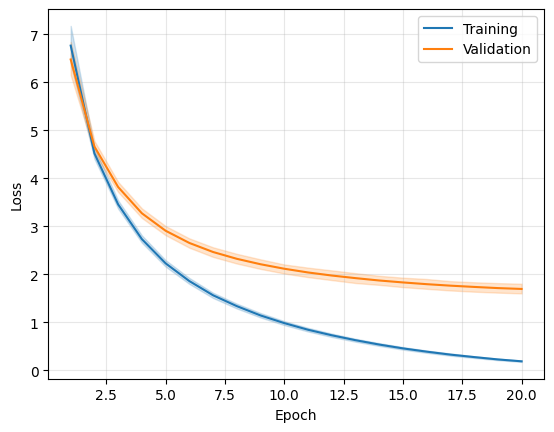

In [19]:
sns.lineplot(data=metrics_df, x="Epoch", y="TrainLoss", label="Training")
sns.lineplot(data=metrics_df, x="Epoch", y="ValLoss", label="Validation")
plt.grid(alpha=0.3)
plt.ylabel("Loss")
plt.show()

In [20]:
torch.save(transformer.state_dict(), MODELS_DIR / "transformer_v1.pth")

## Inference

In [21]:
translator = Transformer(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    vocab_size=VOCAB_SIZE,
).to(DEVICE)

pretrained_weights = torch.load(MODELS_DIR / "transformer_v1.pth")
translator.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [22]:
print(f"{tokenizer.bos_token_id=}")
print(f"{tokenizer.eos_token_id=}")
print(f"{tokenizer.pad_token_id=}")

tokenizer.bos_token_id=0
tokenizer.eos_token_id=2
tokenizer.pad_token_id=1


In [23]:
def translate(model, tokenizer, clip_seq_landmarks, max_tokens, device):
    model.eval()
    clip_seq_landmarks = clip_seq_landmarks.unsqueeze(0).to(device)
    tokens_out = torch.full((1, max_tokens), tokenizer.pad_token_id).to(device)
    tokens_out[0, 0] = tokenizer.bos_token_id
    with torch.no_grad():
        for n_token in range(1, max_tokens):
            masks = create_masks(clip_seq_landmarks, tokens_out)
            masks = [mask.to(device) for mask in masks]
            predictions = transformer(clip_seq_landmarks, tokens_out, *masks)
            next_token_prob_distribution = predictions[0][n_token]
            next_token_index = next_token_prob_distribution.argmax().item()
            if next_token_index == tokenizer.eos_token_id:
                print("End of sentence token reached")
                break
            tokens_out[0, n_token] = next_token_index
    decoded_out = tokenizer.decode(tokens_out[0], skip_special_tokens=True)
    return decoded_out

In [24]:
for _ in range(10):
    random_batch_idx = np.random.randint(0, len(val_dl))
    random_batch_item_idx = np.random.randint(0, BATCH_SIZE)
    print(f"{random_batch_idx=}")
    print(f"{random_batch_item_idx=}")

    random_clip = list(val_dl)[random_batch_idx]

    clip_seq_landmarks = random_clip["in_landmarks"][random_batch_item_idx]
    pl_annotation = tokenizer.decode(random_clip["out_polish_token_ids"][random_batch_item_idx], skip_special_tokens=True)

    translation = translate(translator, tokenizer, clip_seq_landmarks, max_tokens=MAX_SEQUENCE_LENGTH, device=DEVICE)

    print(f"Annotation: {pl_annotation}")
    print(f"Translation: {translation}")
    print()

random_batch_idx=10
random_batch_item_idx=3
Annotation: Pracuję, nie mogę.
Translation: Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten

random_batch_idx=34
random_batch_item_idx=3
Annotation: Żółty trójkąt mówi, że trzeba uważać, żeby nie spaść na dół na nawierzchnię.
Translation: Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten

random_batch_idx=2
random_batch_item_idx=12
Annotation: Podchodzi do niego mały chłopiec, ale Charlie odpycha go od siebie nogą.
Translation: Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten Ten

random_batch_idx=11
random_batch_

## Playground

In [25]:
encoder = Encoder(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH
).to(DEVICE)

In [26]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, N_LANDMARKS) ).to(DEVICE) # includes positional encoding
out = encoder(x, self_attention_mask=None)

out.shape

torch.Size([32, 50, 512])

In [27]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, D_MODEL) ).to(DEVICE)  # seq of frames (landmarks), batched; positional encoded
y = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, MAX_SEQUENCE_LENGTH) ).to(DEVICE)  # batched tokens ids; positional encoded

mask = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , float('-inf')).to(DEVICE)
mask = torch.triu(mask, diagonal=1).to(DEVICE)

decoder = Decoder(D_MODEL, FFN_HIDDEN, NUM_HEADS, DROP_PROB, NUM_LAYERS, MAX_SEQUENCE_LENGTH, VOCAB_SIZE).to(DEVICE)

out = decoder(x, y, mask, mask)

In [28]:
out.shape

torch.Size([32, 50, 512])

In [29]:
transformer = Transformer(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    vocab_size=VOCAB_SIZE,
).to(DEVICE)

In [30]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, N_LANDMARKS) ).to(get_device())
y = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, MAX_SEQUENCE_LENGTH) ).to(get_device())

result = transformer(x, y)

In [31]:
result.shape

torch.Size([32, 50, 50000])

In [32]:
result

tensor([[[-0.6741,  0.1794, -0.6542,  ...,  1.0046, -0.1190,  0.8754],
         [-0.3435,  0.0124, -0.5958,  ..., -0.3289,  0.1823,  0.4486],
         [ 0.3794,  0.1556,  0.2594,  ..., -1.0698, -0.5115,  0.9614],
         ...,
         [-0.0213, -0.8717,  0.4211,  ...,  0.0830, -0.2434, -0.1108],
         [-0.0496, -0.5449,  0.3379,  ...,  0.3444, -0.8640, -0.3080],
         [-0.8405, -0.1635, -0.1503,  ...,  0.6105, -0.4077, -0.9809]],

        [[-0.2821, -0.2361, -0.1269,  ...,  0.0377, -0.6995,  0.2988],
         [-0.8607, -0.1035,  0.1453,  ...,  0.0255, -1.2619,  0.4788],
         [-0.0510,  0.4893,  1.4533,  ...,  1.4625, -1.0268,  0.3633],
         ...,
         [-0.2624, -0.3121,  0.1961,  ...,  0.9089, -0.4298, -0.3597],
         [-0.4059, -0.4654, -0.2810,  ...,  0.1095, -0.9014,  0.1602],
         [-1.1782, -0.0889, -0.4431,  ...,  0.5437, -1.1250, -0.1313]],

        [[-0.3697, -0.3335,  0.1760,  ...,  1.0793, -0.5543,  0.1695],
         [-0.4762,  0.3326,  0.5533,  ...,  0

In [33]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tokenizer.pad_token_id = 1
tokenizer.bos_token_id = 0
tokenizer.eos_token_id = 2

tokenizer.decode(2), tokenizer.eos_token_id, tokenizer.vocab_size

('</s>', 2, 50000)